# Emotional numbing as a 5PL regression model

y = d + (a-d)/(1+(x/c)^b)^g

a theortical response at min</br>
b slope factor</br>
c mid range </br>
d therotical response at max</br>
g asymetrical factor</br>

Participants will rate pictures valence.</br>
We will fit a curve to the valence rating and "known" valence based on the mean from the dataset it was taken from.</br>
Hypothesis: </br>
    1. Depressive symptoms will be correlate with "d"</br>
    2. emotional numbing symptoms will correlate with increase of "b"

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

import matplotlib.pyplot as ply
import seaborn as sns

create a single subject

<AxesSubplot:xlabel='x', ylabel='y'>

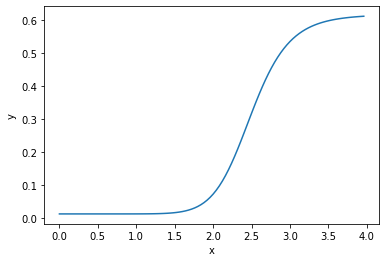

In [2]:
trials = 100
min_r = 0
max_r = 4
a = np.random.beta(1, 20, 1)[0]
b = np.random.normal(10, 2.5, 1)[0]
c = np.random.normal(2.5, .5, 1)[0]
d = np.random.beta(10, 10, 1)[0]
g = np.random.normal(1.1, .2, 1)[0]
x = np.arange(min_r, max_r, max_r/trials)
df = pd.DataFrame({'a': a,     
                   'b': b,    
                   'c': c,
                   'd': d,
                   'g': g,
                   'x': x})
#df['x'] = df.x/20
df['y'] = df.d + (df.a-df.d)/(1+(df.x/df.c)**df.b)**df.g


sns.lineplot(x='x',y='y',data=df)

In [3]:
with pm.Model() as linear:
    a = pm.Normal('a', 0, 5)
    b = pm.Normal('b', 1, 1)
    
    eps = pm.Exponential('eps', 5)
    y_hat = a + b * df.x
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=df['y'].values)
    trace_l = pm.sample(2000, return_inferencedata=True, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, eps]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


In [4]:
with pm.Model() as four_PL:
    
    
    a = pm.Beta('a', 2, 10)
    b = pm.Normal('b',10, 2.5)
    c = pm.Normal('c',2.5, .5)
    d = pm.Beta('d', 10, 10)
    
    eps = pm.Exponential('eps', 5)
    y_hat = d + (a-d)/(1+(df['x'].values/c)**b)
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=df['y'].values)
    trace_4 = pm.sample(2000, return_inferencedata=True, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d, eps]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


In [5]:
with pm.Model() as five_PL:
    
    
    a = pm.Beta('a', 1, 20)
    b = pm.Normal('b',10, 2.5)
    c = pm.Normal('c',2.5, .5)
    d = pm.Beta('d', 10, 10)
    g = pm.Normal('g', 1, .2)
    
    eps = pm.Exponential('eps', 5)
    y_hat = d + (a-d)/(1+(df['x'].values/c)**b)**g
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=df['y'].values)
    trace_5 = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 341 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


In [6]:
comp = az.compare({'Linear model': trace_l,'4PL model': trace_4, '5PL model':trace_5}, ic='loo')
comp

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
5PL model,0,2303.014569,2.942551,0.000000,1.000000e+00,0.142148,0.000000,False,log
4PL model,1,739.879830,5.448499,1563.134739,1.452866e-11,5.703490,5.595337,False,log
Linear model,2,88.658323,2.225202,2214.356246,0.000000e+00,4.578357,4.599957,False,log


<AxesSubplot:xlabel='Log'>

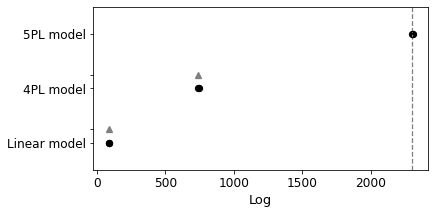

In [7]:
az.plot_compare(comp)

In [8]:
al = az.summary(trace_l, var_names=['a'])[['mean']]
bl = az.summary(trace_l, var_names=['b'])[['mean']]

df_l = pd.DataFrame({'a': al['mean'][0],     
                     'b': bl['mean'][0],    
                     'x': x})

df_l['y'] = df_l.a + df_l.b * df_l.x

In [9]:
a4 = az.summary(trace_4, var_names=['a'])[['mean']]
b4 = az.summary(trace_4, var_names=['b'])[['mean']]
c4 = az.summary(trace_4, var_names=['c'])[['mean']]
d4 = az.summary(trace_4, var_names=['d'])[['mean']]

df_4 = pd.DataFrame({'a': a4['mean'][0],     
                     'b': b4['mean'][0],    
                     'c': c4['mean'][0],
                     'd': d4['mean'][0],
                     'x': x})

df_4['y'] = df_4.d + (df_4.a-df_4.d)/(1+(df_4.x/df_4.c)**df_4.b)

In [10]:
a5 = az.summary(trace_5, var_names=['a'])[['mean']]
b5 = az.summary(trace_5, var_names=['b'])[['mean']]
c5 = az.summary(trace_5, var_names=['c'])[['mean']]
d5 = az.summary(trace_5, var_names=['d'])[['mean']]
g5 = az.summary(trace_5, var_names=['g'])[['mean']]

df_5 = pd.DataFrame({'a': a5['mean'][0],     
                     'b': b5['mean'][0],    
                     'c': c5['mean'][0],
                     'd': d5['mean'][0],
                     'g': g5['mean'][0],
                     'x': x})

df_5['y'] = df_5.d + (df_5.a-df_5.d)/(1+(df_5.x/df_5.c)**df_5.b)**df_5.g

<AxesSubplot:xlabel='x', ylabel='y'>

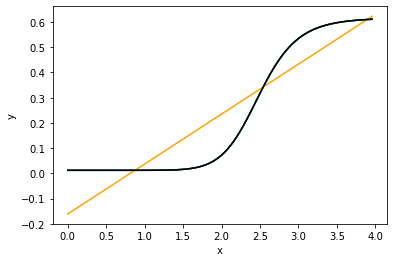

In [11]:
sns.lineplot(x='x',y='y',data=df, color = 'blue')
sns.lineplot(x='x',y='y',data=df_l, color = 'orange')
sns.lineplot(x='x',y='y',data=df_4, color = 'green')
sns.lineplot(x='x',y='y',data=df_5, color = 'black')

No noise all models work great
if we add small noise?

<AxesSubplot:xlabel='x', ylabel='y'>

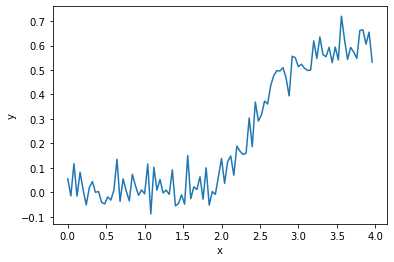

In [12]:
df_noise = pd.DataFrame()
df_noise['a'] = df.a #+ np.random.normal(.02, .01, trials)**2
df_noise['b'] = df.b #+ np.random.normal(1, 1, trials)
df_noise['c'] = df.c #+ np.random.normal(.1, .1, trials)
df_noise['d'] = df.d #+ np.random.normal(.01, .01, trials)**2
df_noise['g'] = df.g #+ np.random.normal(.2, .2, trials)
df_noise['x'] = df.x
df_noise['y'] = df_noise.d + (df_noise.a-df_noise.d)/(1+(df_noise.x/df_noise.c)**df_noise.b)**df_noise.g + np.random.normal(0, .05, trials)

sns.lineplot(x='x',y='y',data=df_noise)

In [13]:
with pm.Model() as five_PL:
        
    
    a = pm.Beta('a', 1, 20)
    b = pm.Normal('b',10, 2.5)
    c = pm.Normal('c',2.5, .5)
    d = pm.Beta('d', 10, 10)
    g = pm.Normal('g', 1, .2)
    
    eps = pm.Exponential('eps', 5)
    y_hat = d + (a-d)/(1+(df_noise['x'].values/c)**b)**g
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=df_noise['y'].values)
    
    trace_5_n = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 24 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [14]:
a5 = az.summary(trace_5_n, var_names=['a'])[['mean']]
b5 = az.summary(trace_5_n, var_names=['b'])[['mean']]
c5 = az.summary(trace_5_n, var_names=['c'])[['mean']]
d5 = az.summary(trace_5_n, var_names=['d'])[['mean']]
g5 = az.summary(trace_5_n, var_names=['g'])[['mean']]

df_5_n = pd.DataFrame({'a': a5['mean'][0],     
                       'b': b5['mean'][0],    
                       'c': c5['mean'][0],
                       'd': d5['mean'][0],
                       'g': g5['mean'][0],
                       'x': x})

df_5_n['y'] = df_5_n.d + (df_5_n.a-df_5_n.d)/(1+(df_5_n.x/df_5_n.c)**df_5_n.b)**df_5_n.g

<AxesSubplot:xlabel='x', ylabel='y'>

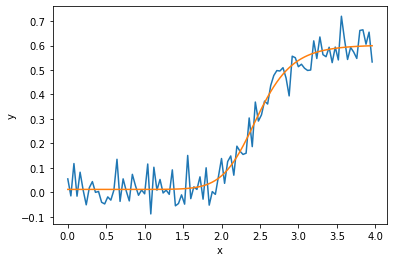

In [15]:
sns.lineplot(x='x',y='y',data=df_noise)
sns.lineplot(x='x',y='y',data=df_5_n)

<AxesSubplot:xlabel='x', ylabel='y'>

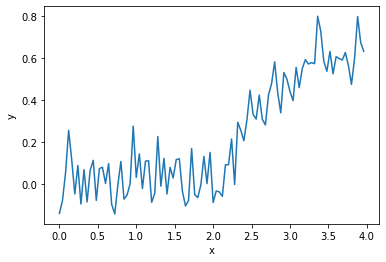

In [16]:
# More noise
df_noise = pd.DataFrame()
df_noise['a'] = df.a #+ np.random.normal(.02, .01, trials)**2
df_noise['b'] = df.b #+ np.random.normal(1, 1, trials)
df_noise['c'] = df.c #+ np.random.normal(.1, .1, trials)
df_noise['d'] = df.d #+ np.random.normal(.01, .01, trials)**2
df_noise['g'] = df.g #+ np.random.normal(.2, .2, trials)
df_noise['x'] = df.x
df_noise['y'] = df_noise.d + (df_noise.a-df_noise.d)/(1+(df_noise.x/df_noise.c)**df_noise.b)**df_noise.g + np.random.normal(0, .1, trials)

sns.lineplot(x='x',y='y',data=df_noise)

In [17]:
with pm.Model() as five_PL:
        
    
    a = pm.Beta('a', 1, 20)
    b = pm.Normal('b',10, 2.5)
    c = pm.Normal('c',2.5, .5)
    d = pm.Beta('d', 10, 10)
    g = pm.Normal('g', 1, .2)
    
    eps = pm.Exponential('eps', 5)
    y_hat = d + (a-d)/(1+(df_noise['x'].values/c)**b)**g
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=df_noise['y'].values)
    
    trace_5_n = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 16 seconds.


In [18]:
a5 = az.summary(trace_5_n, var_names=['a'])[['mean']]
b5 = az.summary(trace_5_n, var_names=['b'])[['mean']]
c5 = az.summary(trace_5_n, var_names=['c'])[['mean']]
d5 = az.summary(trace_5_n, var_names=['d'])[['mean']]
g5 = az.summary(trace_5_n, var_names=['g'])[['mean']]

df_5_n = pd.DataFrame({'a': a5['mean'][0],     
                       'b': b5['mean'][0],    
                       'c': c5['mean'][0],
                       'd': d5['mean'][0],
                       'g': g5['mean'][0],
                       'x': x})

df_5_n['y'] = df_5_n.d + (df_5_n.a-df_5_n.d)/(1+(df_5_n.x/df_5_n.c)**df_5_n.b)**df_5_n.g

<AxesSubplot:xlabel='x', ylabel='y'>

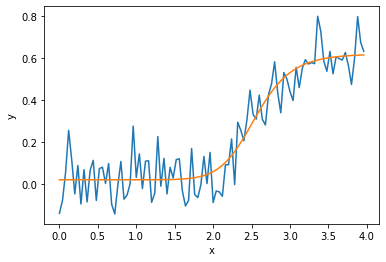

In [19]:
sns.lineplot(x='x',y='y',data=df_noise)
sns.lineplot(x='x',y='y',data=df_5_n)

<AxesSubplot:xlabel='x', ylabel='y'>

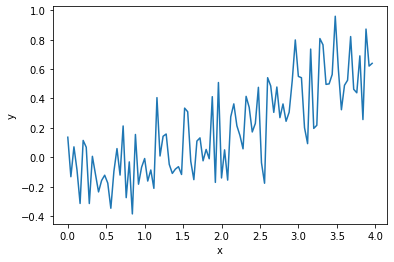

In [20]:
# Even more noise
df_noise = pd.DataFrame()
df_noise['a'] = df.a #+ np.random.normal(.02, .01, trials)**2
df_noise['b'] = df.b #+ np.random.normal(1, 1, trials)
df_noise['c'] = df.c #+ np.random.normal(.1, .1, trials)
df_noise['d'] = df.d #+ np.random.normal(.01, .01, trials)**2
df_noise['g'] = df.g #+ np.random.normal(.2, .2, trials)
df_noise['x'] = df.x
df_noise['y'] = df_noise.d + (df_noise.a-df_noise.d)/(1+(df_noise.x/df_noise.c)**df_noise.b)**df_noise.g + np.random.normal(0, .2, trials)

sns.lineplot(x='x',y='y',data=df_noise)

In [21]:
with pm.Model() as five_PL:
        
    
    a = pm.Beta('a', 1, 20)
    b = pm.Normal('b',10, 2.5)
    c = pm.Normal('c',2.5, .5)
    d = pm.Beta('d', 10, 10)
    g = pm.Normal('g', 1, .2)
    
    eps = pm.Exponential('eps', 5)
    y_hat = d + (a-d)/(1+(df_noise['x'].values/c)**b)**g
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=df_noise['y'].values)
    
    trace_5_n = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 14 seconds.


In [22]:
a5 = az.summary(trace_5_n, var_names=['a'])[['mean']]
b5 = az.summary(trace_5_n, var_names=['b'])[['mean']]
c5 = az.summary(trace_5_n, var_names=['c'])[['mean']]
d5 = az.summary(trace_5_n, var_names=['d'])[['mean']]
g5 = az.summary(trace_5_n, var_names=['g'])[['mean']]

df_5_n = pd.DataFrame({'a': a5['mean'][0],     
                       'b': b5['mean'][0],    
                       'c': c5['mean'][0],
                       'd': d5['mean'][0],
                       'g': g5['mean'][0],
                       'x': x})

df_5_n['y'] = df_5_n.d + (df_5_n.a-df_5_n.d)/(1+(df_5_n.x/df_5_n.c)**df_5_n.b)**df_5_n.g

<AxesSubplot:xlabel='x', ylabel='y'>

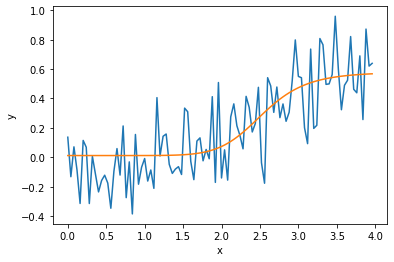

In [23]:
sns.lineplot(x='x',y='y',data=df_noise)
sns.lineplot(x='x',y='y',data=df_5_n)